# Lab 2: Classification
## AirBnB Listings for Los Angeles Area
### Jason McDonald, Miguel Bonilla, Zachary Bunn

**Table of Contents**

- [Data Preparation: Part 1](#Data-Preparation:-Part-1)
    - [Data Wrangling](#Data-Wrangling)
    - [Label and One-Hot Encoding](#Label-and-One-Hot-encoding)
    - [Scaling numerical varialbes](#Scaling-numerical-variables)
- [Data Preparation: Part 2](#Data-Preparation:-Part-2)
- [Modeling and Evaulation 1](#Modeling-and-Evaluation-1)
- [Modeling and Evaulation 2](#Modeling-and-Evaluation-2)
- [Modeling and Evaulation 3](#Modeling-and-Evaluation-3)
    - [Random Forest](#Random-Forest)
    - [NaiveBayes](#NaiveBayes)
    - [SVM](#SVM)
    - [Logistic Regression](#Logistic-Regression)
    - [KNN](#KNN)
- [Modeling and Evaulation 4](#Modeling-and-Evaluation-4)
- [Modeling and Evaulation 5](#Modeling-and-Evaluation-5)
- [Modeling and Evaulation 6](#Modeling-and-Evaluation-6)
- [Deployment](#Deployment)
- [Exceptional Work](#Exceptional-Work)

### Data Preparation: Part 1
Rubric (10 pts): Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

#### Data Wrangling
First of all, we will clean up the data, imputing missing values as done from previous work

In [1]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

#df = pd.read_csv("https://media.githubusercontent.com/media/boneeyah/DS7331_Group/main/Data_Files/airbnb_los_angeles.csv")
df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [2]:
# Removing variables which will not be useful for the classification analysis
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license','host_total_listings_count'
]:
    if col in df:
        del df[col]

In [3]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]

## getting property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [4]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']

In [5]:
## fixing variable types
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [6]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]
df = df.reset_index(drop=True)

In [7]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,7,8,11,12,15,18,20,23]].describe().T

,count,unique,top,freq
name,30580,29942,Boutique Hostel,46
host_name,30580,6604,David,249
host_location,30580,980,"Los Angeles, California, United States",10613
host_is_superhost,30580,2,f,20236
host_identity_verified,30580,2,t,26080
neighbourhood_cleansed,30580,302,Long Beach,1163
property_type,30580,6,Entire unit,21090
room_type,30580,4,Entire home/apt,21433
bathroom_type,30580,3,bath,22738
amenities,30580,28937,"[""Hangers"", ""First aid kit"", ""Heating"", ""Fire ...",40


This table shows the number of unique levels for categorical variables in our dataset, as well as the most common level of each variable along with its frequency count. From this table, we can see that about 1/3 of listings (10613/30580) correspond to a host who has Superhost status. Additionally the table shows that amenities has 28937 unique levels, given the way these are listed for each listing, a decission was made to drop the variable for this project.

#### Label and One-Hot encoding
To be able to use categorical variables when fitting our models, we will first encode these variables using LabelEncoder and OneHotEncoder, which convert variables into categorical variables represented by binary values of 0 and 1. LabelEncoder can be used to convert binary categories into binary values of 0 and 1 for each level of the original variable. OneHotEncoder can be used to covert variables with more than two categorical variables, by creating n-1 columns (where n corresponds to the number of levels in a category).

In [8]:
# Model will focus on classifying superhost status
# since we're encoding with binary response, we can use labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
print('host_is_superhost')
df.host_is_superhost.value_counts()

host_is_superhost


0    20236
1    10344
Name: host_is_superhost, dtype: int64

The value of 0 corresponds to the status of 'f' of the original variable, a quick check shows that the value matches that which was previously found (20236 for 'f').

In [9]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
print('host_identity_verified')
print(df.host_identity_verified.value_counts())

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
print('has_availability')
print(df.has_availability.value_counts())

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
print('instant_bookable')
print(df.instant_bookable.value_counts())

host_identity_verified
1    26080
0     4500
Name: host_identity_verified, dtype: int64
has_availability
1    28785
0     1795
Name: has_availability, dtype: int64
instant_bookable
0    19767
1    10813
Name: instant_bookable, dtype: int64


In [10]:
### new feature host_is_local, from host_location. Binary variable of whether host lives in greater LA area or not.
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])
print('host_is_local')
df.host_is_local.value_counts()

host_is_local


0    19056
1    11524
Name: host_is_local, dtype: int64

With the newly created variable host_is_local replacing host_location, we now have a variable with 2 levels, as opposed to the original with over 900 categories.

To convert host_since from datetime to a useable format, we made the decission to create a new variable, host_for, corresponding to the number of months since the host first listed properties on AirBnB. This was accomplished by subtracting the host_since date from the date on which the data was pulled from AirBnB (06-06-2022).

In [11]:
## new feature host_for, a numerical variable that corresponds to length in months since becoming host
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int64  
 5   host_identity_verified          30580 non-null  int64  
 6   neighbourhood_cleansed          30580 non-null  object 
 7   latitude                        30580 non-null  float64
 8   longitude                       30580 non-null  float64
 9   property_type                   30580 non-null  object 
 10  room_type                       30580 non-null  object 
 11  accommodates                    30580 non-null  int64  
 12  bathroom_number                 

This table shows the remaining variables which need to be One-Hot Encoded (neighbourhood_cleansed, property_type, room_type, bathroom_type) or dropped since they won't be useful for our modeling (name, host_name, amenities, id, host_id.

In [12]:
# One Hot Encoding other categorical variables as a non-sparse dataframe
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables


In [13]:
ohe = OneHotEncoder(drop='first',sparse=True)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame.sparse.from_spmatrix(feature_arr,columns=feature_labels)

In [14]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 311 entries, neighbourhood_cleansed_Adams-Normandie to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311)
memory usage: 668.7 KB


In [15]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(6), int64(8)
memory usage: 3.9 MB


#### Scaling numerical variables
We will rescale our predictors using StandardScaler to ensure all variables are on the same scale so that variable importance is not influenced by the range of values of a variable

In [16]:
from sklearn.preprocessing import StandardScaler
num_columns = ['accommodates','bathroom_number','bedrooms','beds','price','number_of_reviews','review_scores_rating','calculated_host_listings_count','host_for']
scaled = df[num_columns]
scaled = pd.DataFrame(StandardScaler().fit_transform(scaled),columns=scaled.columns)

df[num_columns] = scaled[num_columns]

In [17]:
### clean up temporary files
del df_temp, feature_arr, feature_labels, scaled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(9), int64(5)
memory usage: 3.9 MB


In [18]:
df[num_columns].describe()

,accommodates,bathroom_number,bedrooms,beds,price,number_of_reviews,review_scores_rating,calculated_host_listings_count,host_for
count,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04
mean,3.301366e-14,-2.576025e-14,5.216341e-14,-2.753520e-14,-1.807846e-15,2.795703e-15,1.228706e-15,-8.950920e-15,-2.842752e-15
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-1.107019e+00,-1.783036e+00,-6.610494e-01,-7.509706e-01,-1.243972e+00,-5.770197e-01,-7.623051e+00,-2.716875e-01,-2.069410e+00
25%,-7.045577e-01,-5.371434e-01,-6.610494e-01,-7.509706e-01,-7.143722e-01,-5.400700e-01,-4.401467e-02,-2.716875e-01,-7.273150e-01
50%,-3.020962e-01,-5.371434e-01,-6.610494e-01,-5.794827e-02,-3.259995e-01,-4.045877e-01,2.805693e-01,-2.495258e-01,6.657625e-02
75%,5.028269e-01,7.087490e-01,4.115008e-01,6.350741e-01,4.154395e-01,8.807517e-02,4.915489e-01,-1.387172e-01,7.201097e-01
max,4.929904e+00,1.254473e+01,6.846802e+00,4.793208e+00,3.974347e+00,1.803332e+01,4.915489e-01,1.149618e+01,2.918804e+00


## Data Preparation: Part 2
Rubric  (5 pts): Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

variables:

- host_is_superhost - categorical variable of whether host is a super host (1) or not (0) (label encoded)
- host_identity_verified - categorical variable of whether host identifity has been verified (1) or not (0) (label encoded)
- neighbourhood_cleansed - neighborhorhood on which the listing is located at (One-Hot encoded)
- property_type - category type of listed property (one hot encoded)
- room_type - category type of room(s) of listed property (one hot encoded)
- accommodates - numerical feature of maximum number of guests that can stay at a listing
- bathroom_number - new feature (from bathroom text), for number of bathrooms present at a listing
- bathroom_type - new feature (from bathroom text) for category type of bathroom(s) at a listing (one hot encoded)
- bedrooms - numerical feature of number of bedrooms on the listed property
- beds - numerical variable of number of beds on the listed property
- price - the average daily rate to rent the listed property
- has_availability - categorical variable of whether property is available (1) or not (0) (label encoded)
- number_of_reviews - numerical variable of number of times the property has been reviewed
- review_scores_rating - numerical variable for the review score of the property (from 0-5)
- instant_bookable - categorical variable of whether guest can book the listing automatically (1) or needs to be approved by host first (0) (label encoded)
- calculated_host_listings_count - numerical variable of the total number of listings owned by the property's owner.
- host_is_local - new feature (created from host_location), for whether the property host is local to the greater LA area (1) or not local (0) (label encoded)
- host_for - new feature (created from host_since), for how long (in months) since the host first became an AirBnB host

The final dataset to be used for classification and regression modeling includes numerical variables which have all been scaled (standardized by centering over the mean and scaling over the st. dev), as well as categorical variables which have been encoded as 0s and 1s using label encoding and One-Hot encoding. Our final dataset consists of 30580 entries (AirBnB listed properties in LA), with 18 features (9 categorical variables and 9 numerical variables) represented by 325 columns on a sparse dataframe format.

## Modeling and Evaluation 1
Rubric (10 pts): Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

In [ ]:
### sensitivity (recall) since we want to have a model that does a better job at predicting host is superhost when host is indeed a superhost
### for modeling eval part 4 we will use ROC (return of characteristic) as visual support

## Modeling and Evaluation 2
Rubric (10 pts): Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

Stratified K-fold cross validation works better for datasets where the data is imbalanced, so we will first look into whether our response variable (host_is_superhost) is close to 50-50 or if it sufferes from imbalance

In [19]:
df.host_is_superhost.value_counts()

0    20236
1    10344
Name: host_is_superhost, dtype: int64

We can see that the response variable is imbalanced with 10344/30580 ~ 34% superhost and 20236/30580 ~ 66% not superhost. Therefore we will use stratified 10-fold cross validation, since this methond creates folds that preserve the distribution of each class, making it a better tool for our imbalanced data.

In [20]:
from sklearn.model_selection import StratifiedKFold
import scipy

X = df.loc[:,df.columns != 'host_is_superhost']
y = df.loc[:,df.columns == 'host_is_superhost']
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1024) #setting up random seed for reproducibility

## Modeling and Evaluation 3
Rubric (20 pts): Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

#### Random Forest

In [21]:
### random forest model with the stratified 10-fold cross validation loop
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import scipy

# random forest takes in sparse matrices, so we will convert X into a matrix using scipy
X_mat = scipy.sparse.coo_matrix(X)
X_mat = X_mat.tocsr()

score = []
rf_clf = RandomForestClassifier(max_depth=10, random_state=1024,n_jobs=-1)
for train,test in skf.split(X_mat,y):
    rf_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = rf_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    score.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'sensitivity':cm[0,0]/(cm[0,0]+cm[0,1]),
                'specificity':cm[1,1]/(cm[1,1]+cm[1,0])})
score = pd.DataFrame(score)
print(score)
print('mean accuracy: ',score['accuracy'].mean(),
     '\nmean sensitivity: ',score['sensitivity'].mean(),
     '\nmean specificity: ',score['specificity'].mean())


   accuracy  sensitivity  specificity
0  0.747874     0.346228     0.953063
1  0.734140     0.295938     0.958004
2  0.733486     0.296905     0.956522
3  0.745912     0.347195     0.949605
4  0.758012     0.357834     0.962451
5  0.750491     0.348162     0.956028
6  0.745585     0.352657     0.946614
7  0.730216     0.275362     0.962926
8  0.743623     0.370048     0.934750
9  0.729889     0.277295     0.961443
mean accuracy:  0.7419228253760629 
mean sensitivity:  0.32676253749334233 
mean specificity:  0.9541405995088106


In [22]:
## repeat adjusting tuning parameters to achieve better results
# increasing max depth (largely increases complexity), 
score = []
clf = RandomForestClassifier(max_depth=15, random_state=1024, n_jobs=-1)
for train,test in skf.split(X_mat,y):
    clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    score.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'sensitivity':cm[0,0]/(cm[0,0]+cm[0,1]),
                'specificity':cm[1,1]/(cm[1,1]+cm[1,0])})
score = pd.DataFrame(score)
print(score)
print('mean accuracy: ',score['accuracy'].mean(),
     '\nmean sensitivity: ',score['sensitivity'].mean(),
     '\nmean specificity: ',score['specificity'].mean())

   accuracy  sensitivity  specificity
0  0.779595     0.482592     0.931324
1  0.765206     0.464217     0.918972
2  0.774689     0.491296     0.919466
3  0.779267     0.504836     0.919466
4  0.781884     0.500000     0.925889
5  0.790386     0.505803     0.935771
6  0.771419     0.492754     0.913989
7  0.772400     0.498551     0.912506
8  0.760955     0.443478     0.923381
9  0.760628     0.447343     0.920910
mean accuracy:  0.7736429038587312 
mean sensitivity:  0.48308683504798217 
mean specificity:  0.9221675289506642


In [32]:
## increasing tree depth largely increases computational cost, so we will reduce the number of estimators to compensate and keep computing time reasonable
score = []
rf_clf = RandomForestClassifier(max_depth=150, n_estimators = 45,random_state=1024,n_jobs=-1, class_weight='balanced')
for train,test in skf.split(X_mat,y):
    rf_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = rf_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    score.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'sensitivity':cm[0,0]/(cm[0,0]+cm[0,1]),
                'specificity':cm[1,1]/(cm[1,1]+cm[1,0])})
score = pd.DataFrame(score)
print(score)
print('mean accuracy: ',score['accuracy'].mean(),
     '\nmean sensitivity: ',score['sensitivity'].mean(),
     '\nmean specificity: ',score['specificity'].mean())

   accuracy  sensitivity  specificity
0  0.813277     0.666344     0.888340
1  0.816874     0.661509     0.896245
2  0.819490     0.675048     0.893281
3  0.831916     0.690522     0.904150
4  0.833224     0.694391     0.904150
5  0.827338     0.684720     0.900198
6  0.815566     0.672464     0.888779
7  0.819817     0.680193     0.891251
8  0.811642     0.649275     0.894711
9  0.814912     0.647343     0.900643
mean accuracy:  0.8204054937867886 
mean sensitivity:  0.6721809211448435 
mean specificity:  0.8961746730777873


#### NaiveBayes

#### SVM

#### Logistic Regression

#### KNN

## Modeling and Evaluation 4
Rubric (10 pts): Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

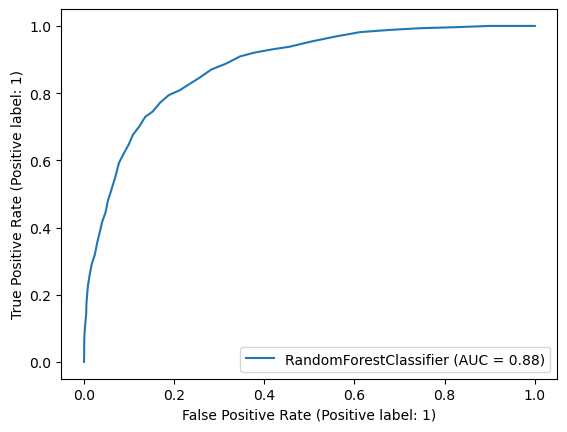

In [35]:
# ROC random forest, for the final product, we could plot all ROC curves under a single plot, leaving this in for now
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.RocCurveDisplay.from_estimator(rf_clf,X_mat[test],y.loc[test])

## Modeling and Evaluation 5
Rubric (10 pts): Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

## Modeling and Evaluation 6
Rubric (10 pts): Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment
Rubric (5 pts): How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work
Rubric (10 pts): You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?


In [ ]:
### thinking of doing 5 models instead of 3